In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model, img_to_array



In [2]:
# Define directories for training and test sets
dir_train = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/'
dir_train_def = dir_train + 'def_front/'
dir_train_ok = dir_train + 'ok_front/'

dir_test = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test/'
dir_test_def = dir_test + 'def_front/'
dir_test_ok = dir_test + 'ok_front/'


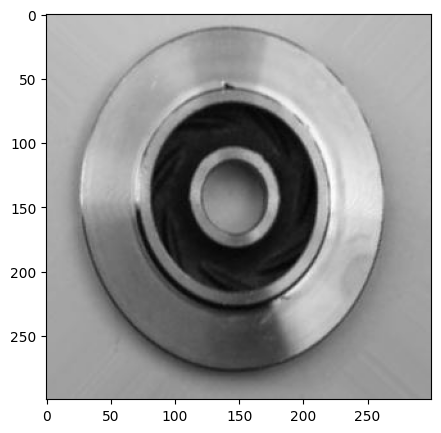

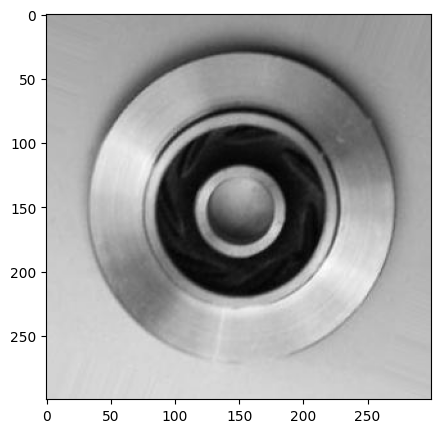

In [3]:
# Display sample images
img = plt.imread(dir_train_def + '/cast_def_0_1001.jpeg')
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')

img1 = plt.imread(dir_train_ok + '/cast_ok_0_1001.jpeg')
plt.figure(figsize=(5,5))
plt.imshow(img1, cmap='gray')

In [4]:
# Image generators with rescaling
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

image_shape, batch_size = (224, 224, 3), 64

arg_train = {'target_size': image_shape[:2],
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}

arg_test = {'target_size': image_shape[:2],
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}


In [5]:
# Load training and validation sets
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)

valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)

# Load test set
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

train_set.class_indices

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


{'def_front': 0, 'ok_front': 1}

In [12]:
!ls /kaggle/models


ls: cannot access '/kaggle/models': No such file or directory


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

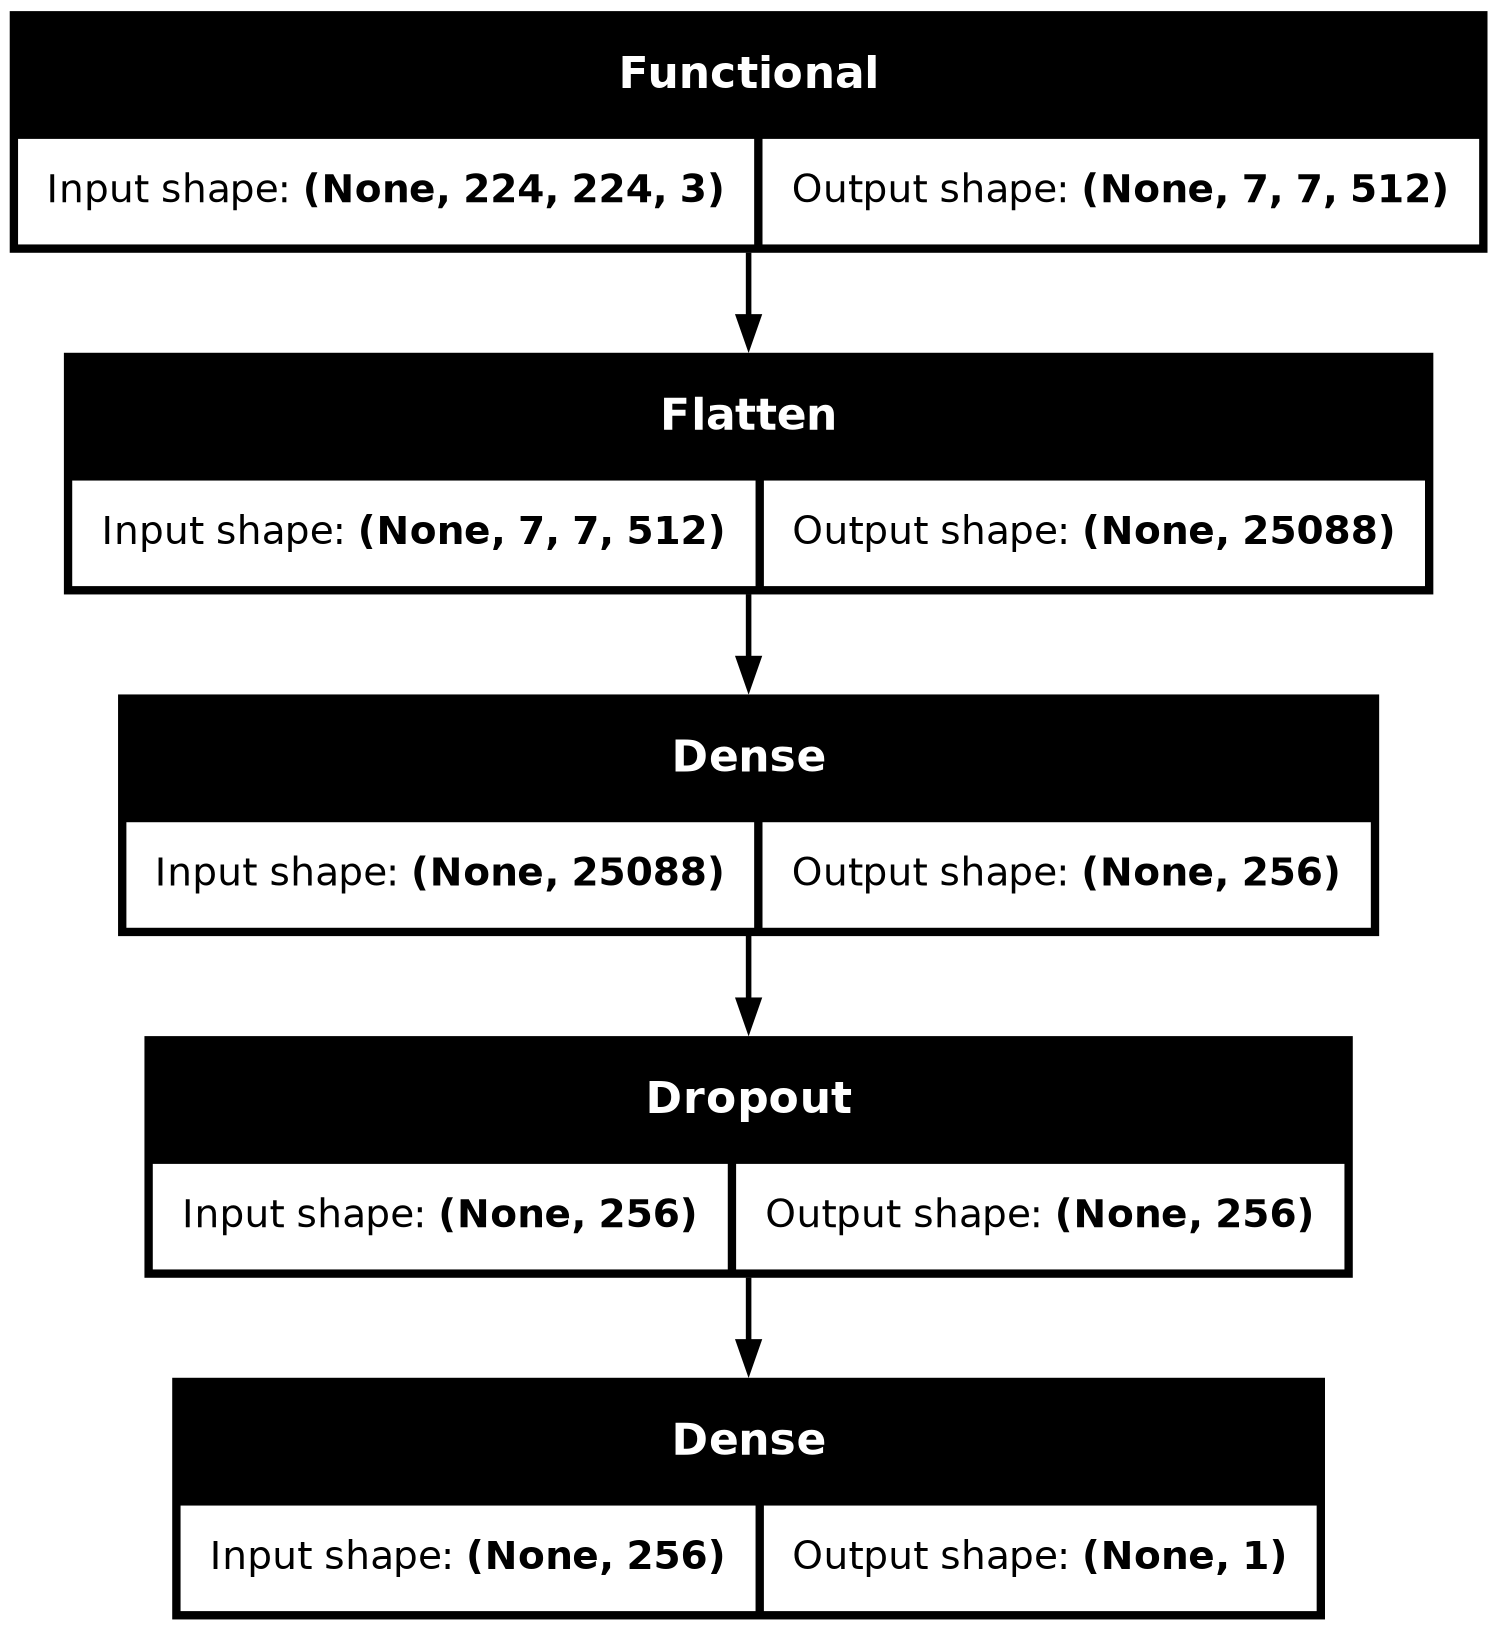

In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Define model structure with VGG16
image_shape = (224, 224, 3)  # Ensure this matches your input image dimensions

# Correct weights path if needed
weights_path = '/kaggle/input/vgg16/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

# Load VGG16 model with pre-trained weights
vgg16_base = VGG16(weights=weights_path, include_top=False, input_shape=image_shape)

# Freeze VGG16 layers
for layer in vgg16_base.layers:
    layer.trainable = False

# Build the full model with custom layers
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Build the model with a specified input shape for plotting
model.build(input_shape=(None, *image_shape))

# Set up callbacks with .h5 extension
model_save_path = 'casting_product_detection_vgg16.keras'
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath=model_save_path, save_best_only=True, monitor='val_loss', verbose=1)

# Plot the model architecture
plot_model(model, show_shapes=True)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6700 - loss: 1.3591 
Epoch 1: val_loss improved from inf to 0.20388, saving model to casting_product_detection_vgg16.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 1700s 20s/step - accuracy: 0.6714 - loss: 1.3510 - val_accuracy: 0.9879 - val_loss: 0.2039
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9482 - loss: 0.2118 
Epoch 2: val_loss improved from 0.20388 to 0.08173, saving model to casting_product_detection_vgg16.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 1690s 20s/step - accuracy: 0.9483 - loss: 0.2115 - val_accuracy: 0.9902 - val_loss: 0.0817
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9698 - loss: 0.1109 
Epoch 3: val_loss improved from 0.08173 to 0.04556, saving model to casting_product_detection_vgg16.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 1692s 20s/step - accuracy: 0.9698 - loss: 0.1108 - val_accuracy: 0.9910 - val_loss: 0.0456
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9816 - loss: 

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'casting_product_detection_vgg16.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

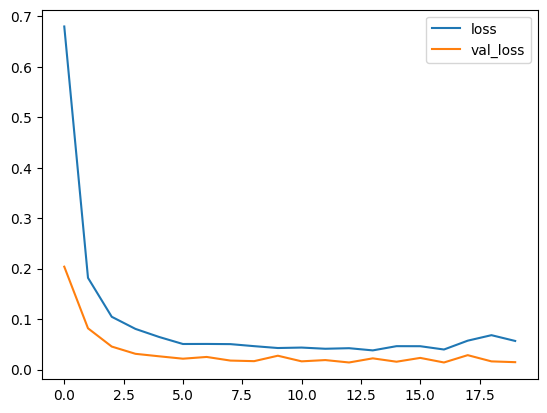

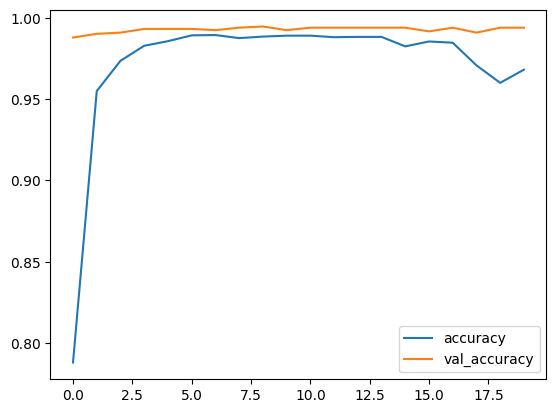

In [25]:
# Train the model
results = model.fit(
    train_set,
    epochs=20,
    validation_data=valid_set,
    callbacks=[early_stop, checkpoint]
)

# Plot the training and validation loss and accuracy
losses = pd.DataFrame(results.history)
losses[['loss', 'val_loss']].plot()
losses[['accuracy', 'val_accuracy']].plot()

# Load the best saved model
model = load_model('casting_product_detection_vgg16.hdf5')


In [26]:
# Predict on the test set
y_pred_prob = model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

# Display classification report
print(classification_report(y_true, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 178s 15s/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       453
           1       0.98      1.00      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



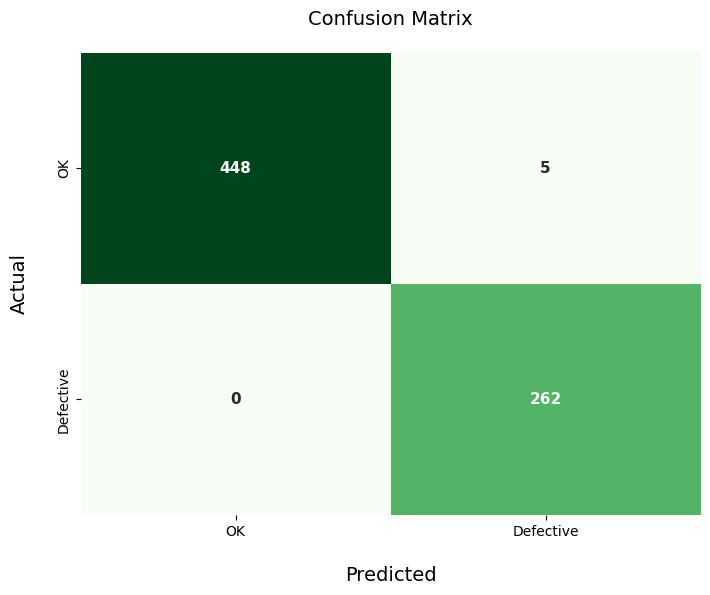

In [27]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True,
                 annot_kws={'size': 11, 'weight': 'bold'},
                 fmt='d', cbar=False, cmap='Greens')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()


In [28]:
# Test individual images and display results
test_cases = ['ok_front/cast_ok_0_10.jpeg', 'ok_front/cast_ok_0_1026.jpeg', 'ok_front/cast_ok_0_1031.jpeg', 'ok_front/cast_ok_0_1121.jpeg', 
              'ok_front/cast_ok_0_1144.jpeg', 'def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


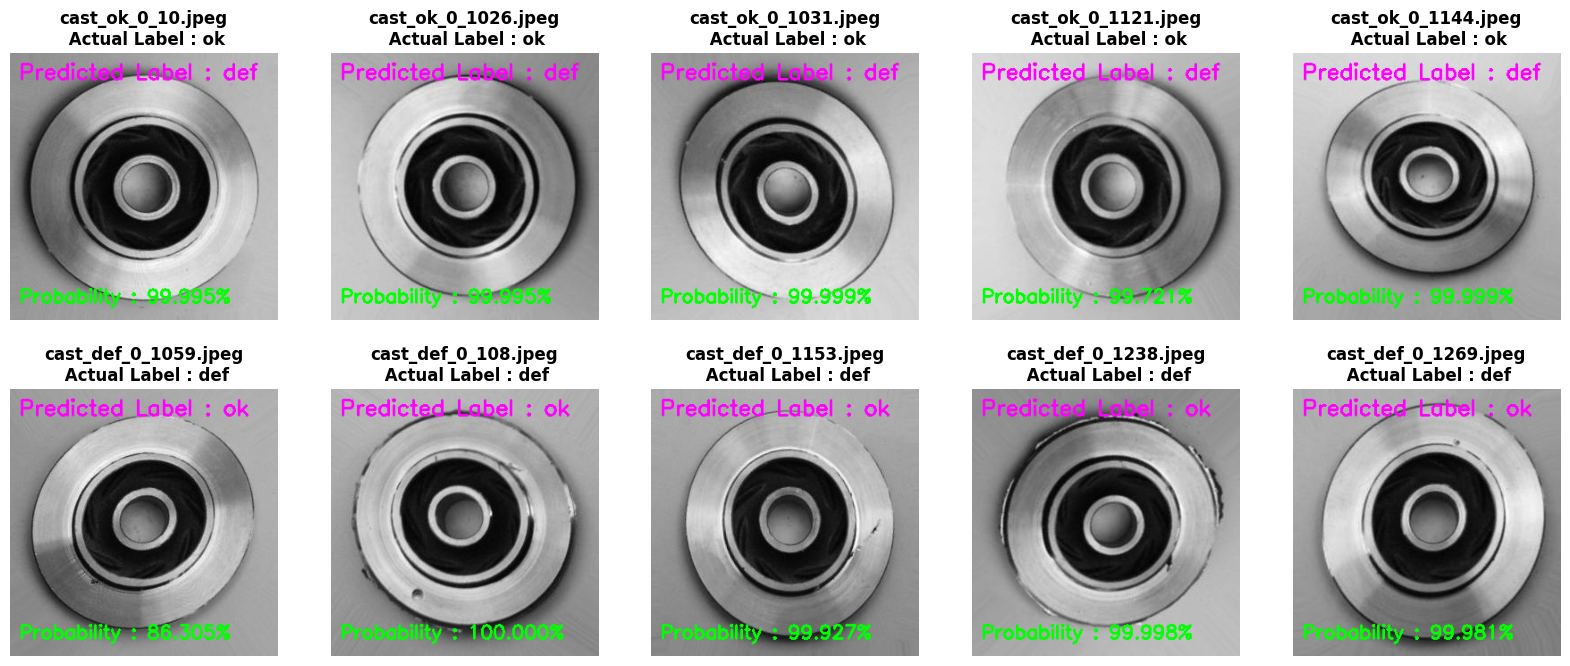

In [29]:
plt.figure(figsize=(20, 8))
for i in range(len(test_cases)):
    img_pred = cv2.imread(dir_test + test_cases[i])
    img_pred = cv2.resize(img_pred, (224, 224))
    img_pred = img_pred / 255
    prediction = model.predict(img_pred.reshape(1, 224, 224, 3))

    img = cv2.imread(dir_test + test_cases[i])
    label = test_cases[i].split("_")[0]

    plt.subplot(2, 5, i + 1)
    plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)

    if (prediction < 0.5):
        predicted_label = "ok"
        prob = (1 - prediction.sum()) * 100
    else:
        predicted_label = "def"
        prob = prediction.sum() * 100

    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()

In [31]:
import tensorflow as tf

# Load the .keras model
model = tf.keras.models.load_model('casting_product_detection_vgg16.keras')

# Save the model in .hdf5 format
model.save('casting_product_detection_vgg16.hdf5')
